In [10]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import sys
 
#%config InlineBackend.figure_formats = {'pdf',}
#%matplotlib inline

import seaborn as sns

plt.close("all") # Clsoe all plots


### Loading data 

Dimensions:  (100, 3)
file: ex2data1.txt
number of features (n): 3
number of examples (m):100

[60.18259939 79.03273605 61.10666454 75.02474557 76.0987867  84.43281996
 82.30705337 69.36458876 53.97105215 69.07014406 70.66150955 76.97878373
 89.67677575 77.92409145 62.27101367 80.19018075 61.37928945 85.40451939
 52.04540477 64.17698887 83.90239366 94.44336777 77.19303493 97.77159928
 62.0730638  91.5649745  79.94481794 99.27252693 90.54671411 97.64563396
 74.24869137 71.79646206 75.39561147 40.45755098 80.27957401 66.74671857
 64.03932042 72.34649423 60.45788574 58.84095622 99.8278578  47.26426911
 50.4581598  88.91389642 94.83450672 67.31925747 57.23870632 80.366756
 68.46852179 75.47770201 78.63542435 94.09433113 90.44855097 74.49269242
 89.84580671 83.48916274 42.26170081 99.31500881 55.34001756 74.775893  ]


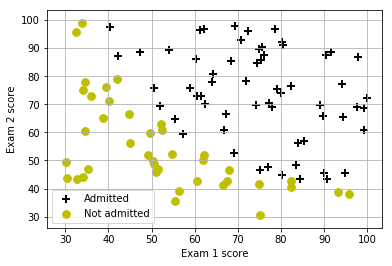

In [11]:
file_name = 'ex2data1.txt'
data = np.loadtxt(file_name, delimiter =',')
print('Dimensions: ',data.shape)

X = np.c_[np.ones((len(data),1)), data[:,0:2]] # create X array colum of 1's and 2 colums of data
y = np.c_[data[:,2]]# create y array colum of output data data

m = X.shape[0] # number of training examples
n = X.shape[1]# number of features... includeing the addition of the 1's

print('file: %s'%(file_name))
print('number of features (n): %.0f'%(n))
print('number of examples (m):%.0f\n'%(m))


def plotData(data, label_x, label_y, label_pos, label_neg, axes = None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0 # ind where all the negative values are
    pos = data[:,2] == 1 # ind where all the postive values are
    
    # If no specific axes object has been passed, get the current axes.
    plt.figure()
    if axes == None:
        axes = plt.gca()
    #plot
    axes.scatter(data[pos][:,0], data[pos][:,1], marker = '+', c = 'k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c ='y', s = 60, label = label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon = True, fancybox = True);
    plt.grid(True)
    
    print(data[pos][:,0])

plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

### Logistic regression

Hypothesis:
Sigmoid Function $$h_\theta(x) = g(\theta^{T}x)$$

$$h_\theta(x) = g(\theta x) = \frac{1}{1 + e^{-\theta^{T}x}}$$

Cost Function:
$$J(\theta) = -\frac{1}{m}\sum_{i = 1}^m \Bigr(y^{(i)}log( h_\theta(x^{(i)})) + (1 - y^{(i)}) log(1 - h_\theta(x^{(i)}))\Bigl)$$

Vectorised Cost Function:
$$ J(\theta) = -\frac{1}{m}\big(log(h)+(1 - y)^T(log(1 - h)\big)$$
where $$h = g(X\theta)$$

Gradient Descent: Repeat until converge
$$\theta_j : = \theta_j- \frac{\alpha}{m}\frac{\delta J(\theta)}{\delta\theta_{j}}$$


Partial derivative:
$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$

Vectorized Partial Derivative
$$\frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h-y)$$



In [ ]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

def costFunction(theta, X, y):
    h = sigmoid(X.dot(theta))
    
    J = -1 * (1/m) * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y))
               
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    
    dJ =(1/m) * X.T.dot(h - y)

    return(dJ.flatten())

initial_theta = np.zeros(X.shape[1])
cost = costFunction(initial_theta, X, y)
dJ = gradient(initial_theta, X, y)

print('-----------------------------------------------------------------')
print('values at initial thetas: %.2f, %.2f, %.2f' %(initial_theta[0], initial_theta[1], initial_theta[2] ))
print('Cost of initial thetas: %.3f'%(cost))
print('Grad Cost: %.3f,  %.3f,  %.3f'%(dJ[0], dJ[1], dJ[2]))
print('-----------------------------------------------------------------')



### Optimisation of cost fucntion

In [4]:
res_opt = minimize(costFunction, initial_theta, args = (X,y), method = None, jac = gradient, options={'maxiter':400})
theta = res_opt.x # set the optimised theta values

C:\Users\michael.morrissey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\michael.morrissey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


### Predict using sklearn

In [5]:


from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

#predicts the pass or fail of students from exam1 & 2 (provided in X)
def predict(theta, X, threshold = 0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold # rue if sigmoid of exams results using optimised theta > 0.5
    return(p.astype('int'))# 1 if true (i.e. pass) 0 = false (i.e. fail)

# Student with Exam 1 score 45 and Exam 2 score 85
# Predict using the optimized Theta values from above
Student_A = np.array([1,45, 85]) 
Student_A_prob = sigmoid(Student_A.dot(theta.T))
grade_Stu_A = predict(theta, Student_A)

Class_Admissions = predict(theta, X)
correct_pred = sum(Class_Admissions == y.ravel())
predict_rate = correct_pred/Class_Admissions.size

print('-----------------------------------------------------------')
print('RESULTS USING THE MINIMISE FUNCTION\n')
print('Optimisation fucntion:minimise()')
print('Values of thetea: %.2f, %.2f %.2f\n'%(theta[0], theta[1], theta[2]))
print('Single Student  results:')
print('student Grades: %.2f,%.2f'%(Student_A[1],Student_A[2]))
print('Predicted Grade: %s'%('PASS' if grade_Stu_A == 1 else 'FAIL')) #prints pass if pass is predited else prints fail
print('Probability of Admission: %.2f%%'%(Student_A_prob * 100))
print('\n')

print('Full Class  results:')
print('number of correction prediction: %.2f'%(correct_pred))
print('Train accuracy %.2f%%'%(100 * predict_rate))
print('-----------------------------------------------------------')


-----------------------------------------------------------
RESULTS USING THE MINIMISE FUNCTION

Optimisation fucntion:minimise()
Values of thetea: -25.16, 0.21 0.20

Single Student  results:
student Grades: 45.00,85.00
Predicted Grade: PASS
Probability of Admission: 77.63%


Full Class  results:
number of correction prediction: 89.00
Train accuracy 89.00%
-----------------------------------------------------------


### Boundary Decision

[60.18259939 79.03273605 61.10666454 75.02474557 76.0987867  84.43281996
 82.30705337 69.36458876 53.97105215 69.07014406 70.66150955 76.97878373
 89.67677575 77.92409145 62.27101367 80.19018075 61.37928945 85.40451939
 52.04540477 64.17698887 83.90239366 94.44336777 77.19303493 97.77159928
 62.0730638  91.5649745  79.94481794 99.27252693 90.54671411 97.64563396
 74.24869137 71.79646206 75.39561147 40.45755098 80.27957401 66.74671857
 64.03932042 72.34649423 60.45788574 58.84095622 99.8278578  47.26426911
 50.4581598  88.91389642 94.83450672 67.31925747 57.23870632 80.366756
 68.46852179 75.47770201 78.63542435 94.09433113 90.44855097 74.49269242
 89.84580671 83.48916274 42.26170081 99.31500881 55.34001756 74.775893  ]


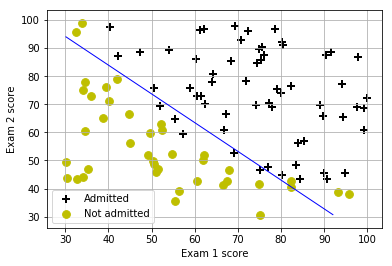

In [23]:
#find the max and min of exam results to create limits for trend line
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max)) 

#create a of X_data in one line... rshape it later.. this is faster
x0_line = np.ones((xx1.ravel().shape[0],1)) 
x1_line = xx1.ravel()
x2_line = xx2.ravel()

h_prep = np.c_[x0_line, x1_line, x2_line].dot(theta)
h = sigmoid(h_prep) # pass it thought the sigmoid fucntion
h = h.reshape(xx1.shape) # rehape it to the size of teh grid

plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b'); 


### Regularised Logistic regression

Note: \theta_0 is not to be regularised adn is calcualted seperately when using the vertorised method

Regularized Cost Function
$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)} log( h_\theta(x^{(i)}))+(1-y^{(i)})log(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}$$


Vectorized Cost Function
$$ J(\theta) = -\frac{1}{m}\big((log(h)^Ty+(log(1-h)^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}$$

Partial derivative:
$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} \frac{\lambda}{m}\theta_{j}^{2}$$

Vectorized Partial Derivative
$$\frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h-y) + \frac{\lambda}{m}\theta_{j}^{2}$$

Gradient Descent: Repeat until converge
$$\theta_0 : = \theta_0- \alpha\frac{1}{m}\frac{\delta J(\theta)}{\delta\theta_{0}}$$

$$\theta_j : = \theta_j- \alpha\Big[\Big(\frac{1}{m}\frac{\delta J(\theta)}{\delta\theta_{j}}\Big) + \frac{\lambda}{m}\theta_{j}\Big] j\epsilon{1,2,3...n}$$
                                

#### Import data

[ 0.051267  -0.092742  -0.21371   -0.375     -0.51325   -0.52477
 -0.39804   -0.30588    0.016705   0.13191    0.38537    0.52938
  0.63882    0.73675    0.54666    0.322      0.16647   -0.046659
 -0.17339   -0.47869   -0.60541   -0.62846   -0.59389   -0.42108
 -0.11578    0.20104    0.46601    0.67339   -0.13882   -0.29435
 -0.26555   -0.16187   -0.17339   -0.28283   -0.36348   -0.30012
 -0.23675   -0.06394    0.062788   0.22984    0.2932     0.48329
  0.64459    0.46025    0.6273     0.57546    0.72523    0.22408
  0.44297    0.322      0.13767   -0.0063364 -0.092742  -0.20795
 -0.20795   -0.43836   -0.21947   -0.13882  ]


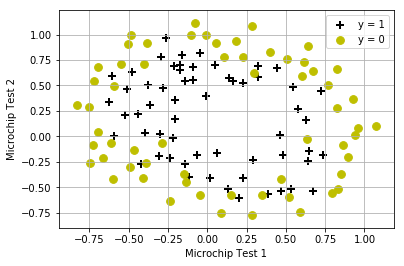

In [24]:
data2 = np.loadtxt('ex2data2.txt', delimiter =',')

y = np.c_[data2[:,2]]
X = data2[:,0:2]

plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')


### Polynomials

In [ ]:
Regularised Liner Regression

[ 0.051267  -0.092742  -0.21371   -0.375     -0.51325   -0.52477
 -0.39804   -0.30588    0.016705   0.13191    0.38537    0.52938
  0.63882    0.73675    0.54666    0.322      0.16647   -0.046659
 -0.17339   -0.47869   -0.60541   -0.62846   -0.59389   -0.42108
 -0.11578    0.20104    0.46601    0.67339   -0.13882   -0.29435
 -0.26555   -0.16187   -0.17339   -0.28283   -0.36348   -0.30012
 -0.23675   -0.06394    0.062788   0.22984    0.2932     0.48329
  0.64459    0.46025    0.6273     0.57546    0.72523    0.22408
  0.44297    0.322      0.13767   -0.0063364 -0.092742  -0.20795
 -0.20795   -0.43836   -0.21947   -0.13882  ]
[ 0.051267  -0.092742  -0.21371   -0.375     -0.51325   -0.52477
 -0.39804   -0.30588    0.016705   0.13191    0.38537    0.52938
  0.63882    0.73675    0.54666    0.322      0.16647   -0.046659
 -0.17339   -0.47869   -0.60541   -0.62846   -0.59389   -0.42108
 -0.11578    0.20104    0.46601    0.67339   -0.13882   -0.29435
 -0.26555   -0.16187   -0.17339   -0.28283

C:\Users\michael.morrissey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


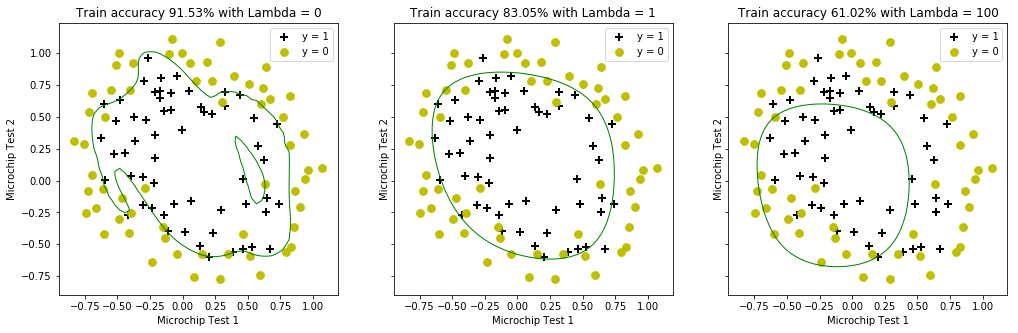

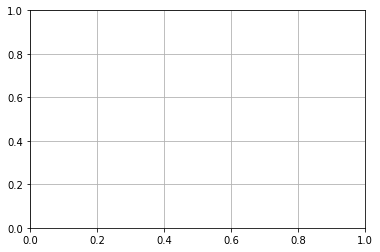

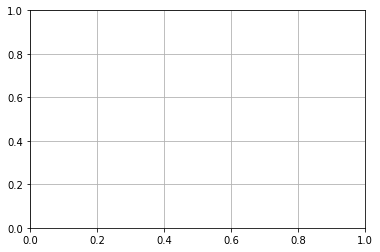

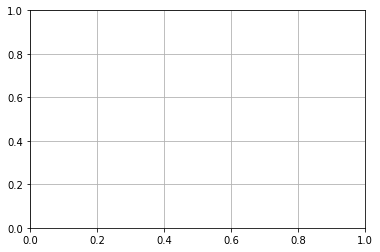

In [25]:
# Note that this function inserts a column with 'ones' in the design matrix for the intercept.
poly = PolynomialFeatures(6)
XX = poly.fit_transform(data2[:,0:2])
XX.shape


# Determine Cost Function
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1*(1/m) * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)) + (reg/(2 * m)) * np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

# Gradient of Regression
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1/m) * XX.T.dot(h - y) + (reg / m) * np.r_[[[0]],theta[1:].reshape(-1, 1)]
        
    return(grad.flatten())

initial_theta = np.zeros(XX.shape[1])
costFunctionReg(initial_theta, 1, XX, y)

fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, C in enumerate([0, 1, 100]):
    # Optimize costFunctionReg

    res_opt2 = minimize(costFunctionReg, initial_theta, args = (C, XX, y), method = None, jac = gradientReg, options = {'maxiter':3000})
    
    # Accuracy
    accuracy = 100 * sum(predict(res_opt2.x, XX) == y.ravel())/y.size    

    # Scatter plot of X,y
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res_opt2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals = 2), C))